In [ ]:
# This notebook analyzes the efficacy of different clustering algorithms for matching design patterns and design problems.
# Note: Table C2 in Hussain et al 2017 seems to indicate that fuzzy c-means clustering with binary weighting is the most effective combination for GoF patterns,
# but TF-IDF yields the highest f-value for fuzzy c-means (0.73).
# We are aiming for an f-value of 0.7 or above.

!pip install unidecode
!pip install fuzzy-c-means
!pip install --upgrade scikit-learn
!pip install scikit-learn-extra

from fcmeans                          import FCM

# Data Structures
import numpy  as np
import pandas as pd
import json
# Corpus Processing
import re
import nltk
import nltk.corpus
from nltk.tokenize                    import word_tokenize
from nltk.stem                        import WordNetLemmatizer
from nltk                             import SnowballStemmer, PorterStemmer
nltk.download('punkt')

from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing            import normalize, Normalizer
from sklearn.decomposition            import PCA, TruncatedSVD
from sklearn.cluster                  import KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn_extra.cluster            import KMedoids
from sklearn.pipeline                 import make_pipeline

from unidecode                        import unidecode

# K-Means
from sklearn                          import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud                        import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
np.random.seed(9)

import pandas as pd
#df_book = pd.read_csv("GoF problem domain (complete).csv")
df_book = pd.read_csv("GOF Patterns (2.0).csv")
#df_book['overview'] = df_book['intent'] + " " + df_book['motivation'] + " " + df_book['applicability']
df_book = df_book.drop_duplicates(subset=['name'])

#df_gof = pd.read_csv("scraped_pattern_data_gofpatterns_revised.csv")
df = df_book

In [ ]:
# Add the design problem to the dataset.
problemRow1 = {'name':"bridge design problem 1", 'correct_category':1, 'overview':"Design a system enabling to display on a screen some empty windows (no button, no menu…). A window can have several different styles depending on the platform used. We consider two platforms, XWindow and Presentation Manager. The client code must be written independently and without knowledge of the future execution platform. It is probable that the system evolves in order to display specialized windows by ‘application windows’ (able to manage applications) and ‘iconised windows’ (with an icon)"}
#problemRow2 = {'name':"state design problem 2", 'correct_category':0,  'overview':"Design a DVD market place work. The DVD marketplace provides DVD to its clients with three categories: children, normal and new. A DVD is new during some weeks, and after change category. The DVD price depends on the category. It is probable that the system evolves in order to take into account the horror category"}
#problemRow3 = {'name':"mediator design problem 3", 'correct_category':0,  'overview':"Design the communications of a plane approaching an airport. When a plane approaches an airport, it must announce to all the other planes which are around that it intends to land, and await their confirmation before carrying out the operation. It is the control tower of the airport which guarantees the regulation of the air traffic, by making sure that there is no trajectory or destination conflict between several planes. In addition to the class diagram, you must also submit a collaboration (in the form of a diagram of collaboration or a diagram of objects and sequence) that describes the landing of a plane amidst in a context of two demands to land and one wanting to take off"}
#problemRow4 = {'name':"composite design problem 4", 'correct_category':1, 'overview':"Design a system enabling you to draw a graphic image. A graphic image is composed of lines, rectangles, texts, and images. An image may be composed of other images, lines, rectangles, and texts"}
#problemRow5 = {'name':"decorator design problem 5", 'correct_category':1, 'overview':"Design a system enabling you to display visual objects on a screen. A visual object can be composed of one or more texts or images. If needed, the system must allow the addition of a vertical scroll bar, a horizontal scroll bar, an edge and a menu to this object. These additions may be accumulated."}
#problemRow6 = {'name':"chain of responsbility design problem 6", 'correct_category':0, 'overview':"Design a help manager for a Java application. A help manager allows the display of a help message depending on the objects on which a client has clicked. For example, the “?”, sometimes located near the contextual menu of a Windows dialog box, allows the display of the help related to the button or the area where to click. If the button on which one clicks does not contain help, it is the area container which displays its help, and so on. If any object contains help, the help manager displays /“No help available for this area/”. Instantiate your class diagram in a sequence diagram of the example of a printing window. This window (JDialog) consists in an explanatory text (JLabel) and in a container (JPanel). This last contains a /“Print button/” (JButton) and a /“Cancel button/” (JButton). The /“Print button/” contains help /“Launches the impression of the document/”. The /“Cancel button/” the text as well as the window do not contain help. Lastly, the container contains help /“Click on one of the buttons/”. In the sequence diagram, reveal the scenarios: /“The user asks for the help of the Print button/”, /“the user asks for the help of the Cancel button/”, and /“the user asks for the help of the text/”"}
#problemRow7 = {'name':"command design problem 7", 'correct_category':0, 'overview':"Design a tutorial to learn how to program a calculator. This calculator executes the four basic arithmetic operations. The goal of this tutorial is to make it possible to take a set of operations to be executed sequentially. The tutorial presents a button for each arithmetic operation, and two input fields for the operands. After each click on a button of an operation, the user has then the choice to start again or execute the sequence of operations to obtain the result. It is probable that this tutorial evolves in order to make it possible for the user to remove the last operation of the list and to take into account the operation of modulo"}
#problemRow8 = {'name':"visitor design problem 8", 'correct_category':0, 'overview':"Many distinct and unrelated operations need to be performed on node objects in a heterogeneous aggregate structure. You want to avoid ‘polluting’ the node classes with these operations. And, you don't want to have to query the type of each node and cast the pointer to the correct type before performing the desired operation."}
#problemRow9 = {'name':"adapter design problem 9", 'correct_category':1, 'overview':"Design a drawing editor. A design is composed of te graphics (lines, rectangles and roses), positioned at precise positions. Each graphic form must be modeled by a class that provides a method draw(): void. A rose is a complex graphic designed by a black-box class component. This component performs this drawing in memory, and provides access through a method getRose(): int that returns the address of the drawing. It is probable that the system evolves in order to draw circles"}
# TODO: we need some design problems related to creational patterns
df = df.append(problemRow1, ignore_index=True)
#df = df.append(problemRow2, ignore_index=True)
#df = df.append(problemRow3, ignore_index=True)

# try removing object words from design problem such as DVD, PLANE, etc...


In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [ ]:
nltk.download('stopwords')
def processCorpus(corpus, language, stemmer):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = stemmer
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = str(corpus[index]).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
corpus = df['overview'].tolist()
corpus[18][0:447]

'Define a one-to-many dependency between objects so that when one object changes state, all its dependents are notified and updated automatically. A common side-effect of partitioning a system into a collection of cooperating classes is the need to maintain consistency between related objects. You don’t want to achieve consistency by making the classes tightly coupled, because that reduces their reusability.\n\nFor example, many graphical user in'

In [ ]:
language = 'english'
stemmer = PorterStemmer()
corpus = processCorpus(corpus, language, stemmer)
corpus[18][0:460]

'defin one-to-mani depend object one object chang state depend notifi updat automat common side-effect partit system collect cooper class need maintain consist relat object want achiev consist make class tightli coupl reduc reusabl exampl mani graphic user interfac toolkit separ present aspect user interfac underli applic data class defin applic data present reus independ work togeth spreadsheet object bar chart object depict inform applic data object use d'

In [ ]:
def vectorize_with_lsa(X_tfidf, n_comp):
  lsa = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
  X_lsa = lsa.fit_transform(X_tfidf)
  explained_variance = lsa[0].explained_variance_ratio_.sum()

  print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

  return X_lsa

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

24 rows


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
famili,0.288229,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.095499,0.0,0.0,0.0
feel,0.238179,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
and,0.218004,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
widget,0.216179,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.078957,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
factori,0.188763,0.0,0.187544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.094351,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [ ]:
# from google.colab import files
# final_df.to_csv('GOF Patterns (2.0) tfidf sublinear.csv', encoding = 'utf-8-sig') 
# files.download('GOF Patterns (2.0) tfidf sublinear.csv')

In [ ]:
# kmeans = KMeans(
#     n_clusters=3
# )

# kmeans.fit_predict(tf_idf)

In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)
inertias = []

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k)
        kmeans_results.update( {k : kmeans.fit(data)} )
        inertias.append((kmeans_results.get(k)).inertia_)
        
    return kmeans_results

In [ ]:
# fix the seed so that we get the same result across runs
np.random.seed(2023)

# Running Kmeans
inertias.clear()
k = 9
kmeans_results = run_KMeans(k, final_df)


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

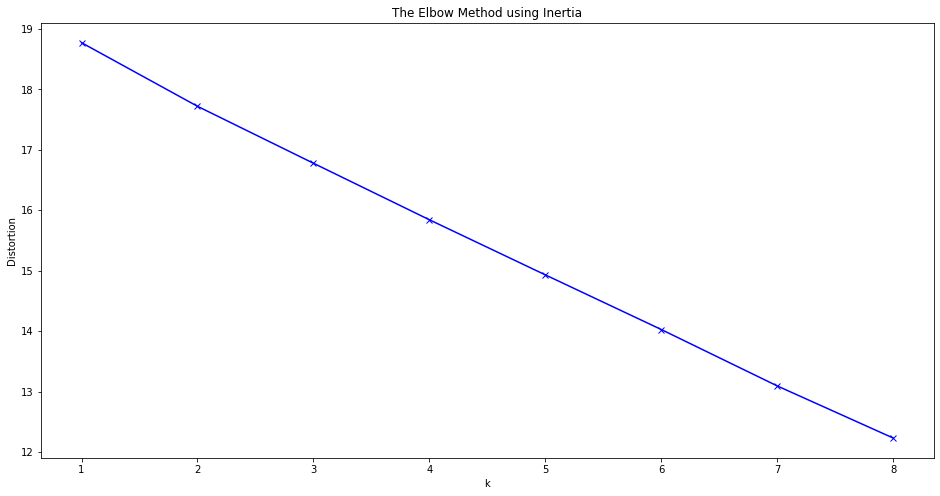

In [ ]:
K = range(1, k)
plt.figure(figsize=(16,8))

# Elbow Method using inertia
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

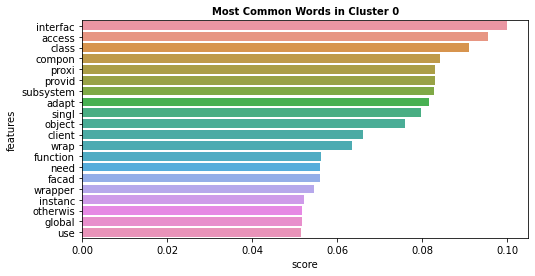

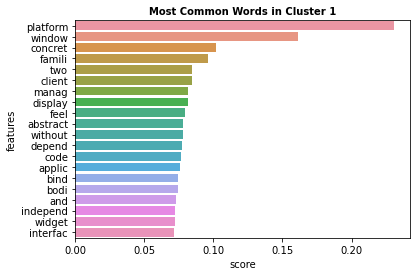

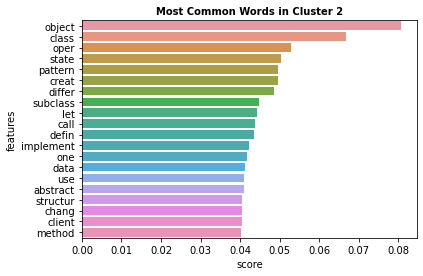

In [ ]:
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 20)

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

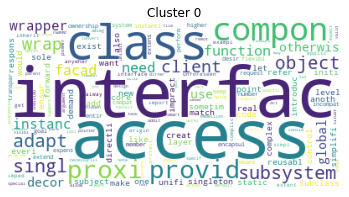

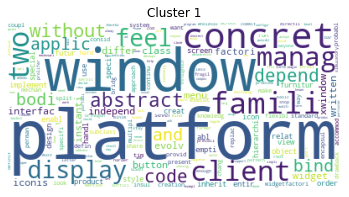

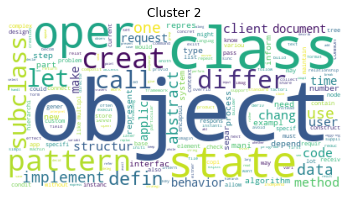

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
# Assigning the cluster labels to each pattern
Kmeans_labels = kmeans.labels_ 
df['Kmeans'] = Kmeans_labels

In [ ]:
print("Cluster centroids: \n")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
tempk = 3
for i in range(tempk):
  print("Cluster %d:" % i)
  for j in order_centroids[i, :20]: #print out 10 features terms of each cluster
    print('%s'% terms[j])
  print('------------------')

Cluster centroids: 

Cluster 0:
interfac
access
class
compon
proxi
provid
subsystem
adapt
singl
object
client
wrap
function
need
facad
wrapper
instanc
otherwis
global
use
------------------
Cluster 1:
platform
window
concret
famili
two
client
manag
display
feel
abstract
without
depend
code
applic
bodi
bind
and
independ
widget
interfac
------------------
Cluster 2:
object
class
oper
state
pattern
creat
differ
subclass
let
call
defin
implement
one
data
use
abstract
structur
chang
client
method
------------------


In [ ]:
# bisecting_strategy{“biggest_inertia”, “largest_cluster”}, default=”biggest_inertia”
Bi_Bisect = BisectingKMeans(n_clusters=3, bisecting_strategy="biggest_inertia")
Lc_Bisect = BisectingKMeans(n_clusters=3, bisecting_strategy="largest_cluster")
Hierarchy = AgglomerativeClustering(n_clusters=3)
Fuzzy_Means = FCM(n_clusters=3)
Fuzzy_Means.fit(final_df_array)
kmed = KMedoids(n_clusters=3)
kmed_manhattan = KMedoids(n_clusters=3,metric='manhattan')

fuzzy_labels = Fuzzy_Means.predict(final_df_array)
bi_bisect_labels = Bi_Bisect.fit_predict(final_df)
lc_bisect_labels = Lc_Bisect.fit_predict(final_df)  
hierarchy_labels = Hierarchy.fit_predict(final_df)
kmed_labels = kmed.fit_predict(final_df)
kmed_man_labels = kmed_manhattan.fit_predict(final_df)

df['fuzzy'] = fuzzy_labels
df['hierarchy'] = hierarchy_labels
df['Bi_Bisect'] = bi_bisect_labels  
df['Lc_Bisect'] = lc_bisect_labels
df['PAM-EUCLIDEAN'] = kmed_labels
df['PAM-MANHATTAN'] = kmed_man_labels


In [ ]:
df

,Unnamed: 0,name,correct_category,overview,Kmeans,fuzzy,hierarchy,Bi_Bisect,Lc_Bisect,PAM-EUCLIDEAN,PAM-MANHATTAN
0,0.0,abstract factory,2,Provide an interface for creating families of ...,1,0,0,0,2,2,1
1,1.0,builder,2,The Builder pattern captures all these relatio...,2,0,0,0,2,1,0
2,2.0,factory method,2,"Define an interface for creating an object, bu...",2,0,0,1,2,2,0
3,3.0,prototype,2,Specify the kinds of objects to create using a...,2,0,2,1,2,0,0
4,4.0,singleton,2,"Ensure a class only has one instance, and prov...",0,2,2,1,2,0,0
5,5.0,adapter,1,Convert the interface of a class into another ...,0,0,0,0,1,2,2
6,6.0,bridge,1,Decouple an abstraction from its implementatio...,1,1,0,1,0,2,1
7,7.0,composite,1,Compose objects into tree structures to repres...,2,1,1,2,2,1,0
8,8.0,decorator,1,Attach additional responsibilities to an objec...,0,2,0,1,2,0,2
9,9.0,facade,1,Provide a unified interface to a set of interf...,0,2,0,1,1,0,1


In [ ]:
# TODO: use k-means before this chunk of code to classify the problem with a pattern class, then perform cosine similarity with the problem and the list of candidate patterns from that class.
# Source: https://danielcaraway.github.io/html/sklearn_cosine_similarity.html



def cosine_sim(df, df_col, class_no, pos_to_last):
  unigram_count = CountVectorizer(encoding='latin-1', binary=False)
  unigram_count_stop_remove = CountVectorizer(encoding='latin-1', binary=False, stop_words='english')

  # get the list of candidate patterns
  txts = df_col.loc[df['Kmeans'] == class_no] # where label == class_no
  vecs = unigram_count.fit_transform(txts)
  
  cos_sim = cosine_similarity(vecs[-pos_to_last], vecs)
  sim_sorted_doc_idx = cos_sim.argsort()
  # print the most similar pattern to the problem; it's actually the problem itself
  print("Design Problem: \n" + txts.iloc[sim_sorted_doc_idx[-1][len(txts)-1]] + "\n")

  bestFittingPatternDesc = txts.iloc[sim_sorted_doc_idx[-1][len(txts)-2]]

  # print the second most similar pattern; it's likely the best-fitting design pattern for the design problem
  #print(txts[sim_sorted_doc_idx[-1][len(txts)-2]])
  print("\nCorrect Pattern: " + (df['name'][(df['overview'] == bestFittingPatternDesc)]).to_string(index=False) + "\n")

  return cos_sim

#cosine_sim(df, df['overview'], df['Kmeans'].iloc[df.index[-3]], 3)
#cosine_sim(df, df['overview'], df['Kmeans'].iloc[df.index[-3]], 2)
cosine_sim(df, df['overview'], df['Kmeans'].iloc[df.index[-1]], 1)

Design Problem: 
Design a system enabling to display on a screen some empty windows (no button, no menu…). A window can have several different styles depending on the platform used. We consider two platforms, XWindow and Presentation Manager. The client code must be written independently and without knowledge of the future execution platform. It is probable that the system evolves in order to display specialized windows by ‘application windows’ (able to manage applications) and ‘iconised windows’ (with an icon)


Correct Pattern: bridge



array([[0.4336418 , 0.54041105, 1.        ]])

In [ ]:
df2 = df.pivot_table(index = ['correct_category'], aggfunc ='size')

num_of_creational = df2[2]
num_of_structural = df2[1]
num_of_behavioral = df2[0]

true_1 = [0]*num_of_creational + [1]*num_of_structural + [2]*num_of_behavioral
true_2 = [0]*num_of_creational + [2]*num_of_structural + [1]*num_of_behavioral
true_3 = [1]*num_of_creational + [0]*num_of_structural + [2]*num_of_behavioral
true_4 = [1]*num_of_creational + [2]*num_of_structural + [0]*num_of_behavioral
true_5 = [2]*num_of_creational + [0]*num_of_structural + [1]*num_of_behavioral
true_6 = [2]*num_of_creational + [1]*num_of_structural + [0]*num_of_behavioral


print('===========KMEANS===========')
print('Predicted labels:')
display(Kmeans_labels.tolist())

fscores = [
    f1_score(true_1, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_2, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_3, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_4, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_5, Kmeans_labels.tolist(),average='micro'),
    f1_score(true_6, Kmeans_labels.tolist(),average='micro')
]

km_best = np.around(max(fscores),3)
print('\nBest fscore is:', km_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========FUZZY-CMEANS===========')
print('Predicted labels:')
fuzzy_labels = fuzzy_labels.tolist()
display(fuzzy_labels)

fscores = [
    f1_score(true_1, fuzzy_labels,average='micro'),
    f1_score(true_2, fuzzy_labels,average='micro'),
    f1_score(true_3, fuzzy_labels,average='micro'),
    f1_score(true_4, fuzzy_labels,average='micro'),
    f1_score(true_5, fuzzy_labels,average='micro'),
    f1_score(true_6, fuzzy_labels,average='micro')
]

fcm_best = np.around(max(fscores),3)
print('\nBest fscore is:', fcm_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========AGGLOMERATIVE===========')
print('Predicted labels:')
display(hierarchy_labels.tolist())

fscores = [
    f1_score(true_1, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_2, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_3, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_4, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_5, hierarchy_labels.tolist(),average='micro'),
    f1_score(true_6, hierarchy_labels.tolist(),average='micro')
]

agg_best = np.around(max(fscores),3)
print('\nBest fscore is:', agg_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========PAM-EUCLIDEAN===========')
print('Predicted labels:')
display(kmed_labels.tolist())

fscores = [
    f1_score(true_1, kmed_labels.tolist(),average='micro'),
    f1_score(true_2, kmed_labels.tolist(),average='micro'),
    f1_score(true_3, kmed_labels.tolist(),average='micro'),
    f1_score(true_4, kmed_labels.tolist(),average='micro'),
    f1_score(true_5, kmed_labels.tolist(),average='micro'),
    f1_score(true_6, kmed_labels.tolist(),average='micro')
]

pam_best = np.around(max(fscores),3)
print('\nBest fscore is:', pam_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('===========PAM-MANHATTAN===========')
print('Predicted labels:')
display(kmed_man_labels.tolist())

fscores = [
    f1_score(true_1, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_2, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_3, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_4, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_5, kmed_man_labels.tolist(),average='micro'),
    f1_score(true_6, kmed_man_labels.tolist(),average='micro')
]

pam_manh_best = np.around(max(fscores),3)
print('\nBest fscore is:', pam_manh_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('========BIG-INERTIA-BISECT========')
print('Predicted labels:')
display(bi_bisect_labels.tolist())

fscores = [
    f1_score(true_1, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_2, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_3, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_4, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_5, bi_bisect_labels.tolist(),average='micro'),
    f1_score(true_6, bi_bisect_labels.tolist(),average='micro')
]

bi_bisect_best = np.around(max(fscores),3)
print('\nBest fscore is:', bi_bisect_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

print('========LARGE-CLUST-BISECT========')
print('Predicted labels:')
display(lc_bisect_labels.tolist())

fscores = [
    f1_score(true_1, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_2, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_3, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_4, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_5, lc_bisect_labels.tolist(),average='micro'),
    f1_score(true_6, lc_bisect_labels.tolist(),average='micro')
]

lc_bisect_best = np.around(max(fscores),3)
print('\nBest fscore is:', lc_bisect_best, 'from true_' + str(np.argmax(fscores) + 1))
display(globals()['true_' + str(np.argmax(fscores) + 1)])

===========KMEANS===========
Predicted labels:


[1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


Best fscore is: 0.625 from true_3


[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

===========FUZZY-CMEANS===========
Predicted labels:


[0, 0, 0, 0, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2]


Best fscore is: 0.625 from true_2


[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========AGGLOMERATIVE===========
Predicted labels:


[0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0]


Best fscore is: 0.5 from true_2


[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========PAM-EUCLIDEAN===========
Predicted labels:


[2, 1, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2]


Best fscore is: 0.542 from true_5


[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

===========PAM-MANHATTAN===========
Predicted labels:


[1, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 2, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 2, 1]


Best fscore is: 0.458 from true_1


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

========BIG-INERTIA-BISECT========
Predicted labels:


[0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0]


Best fscore is: 0.542 from true_1


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

========LARGE-CLUST-BISECT========
Predicted labels:


[2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]


Best fscore is: 0.542 from true_1


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

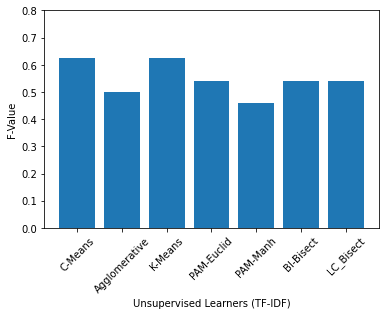

In [ ]:
data = [fcm_best, agg_best, km_best, pam_best, pam_manh_best, bi_bisect_best, lc_bisect_best]
labels = ['C-Means', 'Agglomerative', 'K-Means','PAM-Euclid','PAM-Manh', 'BI-Bisect', 'LC_Bisect']
plt.xticks(range(len(data)), labels)
plt.ylim([0, 0.8])
plt.xlabel('Unsupervised Learners (TF-IDF)')
plt.ylabel('F-Value')
plt.bar(range(len(data)), data) 
plt.xticks(rotation=45)
plt.show()